In [1]:
import matplotlib.pyplot as plt
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain, Election
from gerrychain.updaters import cut_edges, Tally
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial

/Users/shelger/miniconda3/envs/langchain/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import time
import pandas as pd
import geopandas as gpd
start_time = time.time()

In [3]:
la_graph = Graph.from_file("./shapefiles/la_election_shapefile.shp")
assignment = {node: la_graph.nodes[node]['CD'] for node in la_graph.nodes()}
def democratic_wins(partition):
    dem_won_districts = 0
    for district in partition.parts:
        dem_votes = sum(partition.graph.nodes[node]["G20PRED"] for node in partition.parts[district])
        rep_votes = sum(partition.graph.nodes[node]["G20PRER"] for node in partition.parts[district])
        if dem_votes > rep_votes:
            dem_won_districts += 1
    return dem_won_districts

initial_partition = Partition(
    la_graph, # dual graph
    assignment = assignment,
    updaters={
    "our cut edges": cut_edges,         
    "district population": Tally("TOTPOP", alias = "district population"), # across districts, add total population
    "district latino": Tally("HISP", alias = "district latino"), 
    "district democratic wins": democratic_wins,
})

tot_pop = sum([la_graph.nodes()[v]['TOTPOP'] for v in la_graph.nodes()])
num_dist = 6
pop_tolerance = 0.02
ideal_pop = tot_pop/num_dist

In [8]:
print(la_graph)

Graph with 3753 nodes and 10494 edges


In [4]:
rw_proposal = partial(recom, ## how you choose a next districting plan
                      pop_col = "TOTPOP", ## What data describes population? 
                      pop_target = ideal_pop, ## What the target/ideal population is for each district 
                                              ## (we calculated ideal pop above)
                      epsilon = pop_tolerance,  ## how far from ideal population you can deviate
                                              ## (we set pop_tolerance above)
                      node_repeats = 1 ## number of times to repeat bipartition.  Can increase if you get a BipartitionWarning
                      )
population_constraint = constraints.within_percent_of_ideal_population(
    initial_partition, 
    pop_tolerance, 
    pop_key="district population")

In [5]:
our_random_walk = MarkovChain(
    proposal = rw_proposal, 
    constraints = [population_constraint],
    accept = always_accept, # Accept every proposed plan that meets the population constraints
    initial_state = initial_partition, 
    total_steps = 10) 

[750, 739, 584, 486, 405, 451, 448, 443, 438, 428]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
The time of execution of above program is : 0.7953732530275981 mins


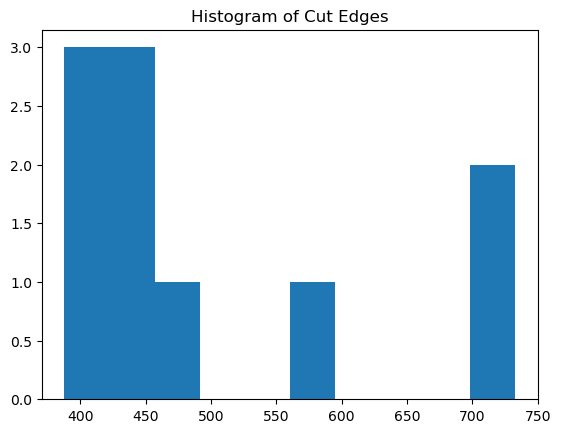

In [6]:
cutedge_ensemble = []
# latino_ensemble = []
demo_ensemble = []

for part in our_random_walk:
    # Add cutedges to cutedges ensemble
    cutedge_ensemble.append(len(part["our cut edges"]))
    demo_ensemble.append(part["district democratic wins"])
    # Calculate number of black-majority districts 
    # Add to ensemble
    # num_latino = 0
    # for i in range(num_dist):
        # latino_perc = part["district latino"][i] / part["district population"][i]
        # if latino_perc >= 0.5:
        #     num_latino = num_latino + 1
    # latino_ensemble.append(num_latino)

print(cutedge_ensemble)
# print(latino_ensemble)
print(demo_ensemble)

# cutting edges
plt.figure()
plt.hist(cutedge_ensemble, align = 'left')
plt.title('Histogram of Cut Edges')
# plt.show()
plt.savefig('Cutting_Edges.png')

#  Majority Latinos
# plt.figure()
# bins = range(5)
# plt.hist(latino_ensemble, bins = bins, align = 'left')
# plt.title('Histogram of Majority Latinos')
# # plt.show()
# plt.savefig('Latinos.png')

plt.figure()
plt.hist(demo_ensemble, align = 'left')
plt.title('Histogram of Democratic Wins')
# plt.show()
plt.savefig('Democratic.png')
plt.close()

end_time = time.time()
print("The time of execution of above program is :",
      (end_time-start_time)/60, "mins")